<a href="https://colab.research.google.com/github/PremKumar-V/Advance_Projects/blob/main/LLM_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
import re
import string
import requests
import random

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer, ngrams_iterator

In [2]:
DATA_URL = 'https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/4.4%20-%20Lab%20-%20Word-Level%20RNN/fairy_tales_cleaned_most_common_5000_words.txt'
FILE_PATH = './data.txt'

def getData():
    response = requests.get(DATA_URL)
    with open(FILE_PATH, 'w') as file:
        file.write(response.text)

    with open(FILE_PATH, 'r') as file:
        text = file.read()

    return text

data = getData()

In [3]:
print(f"Length of Data: {len(data)}")

Length of Data: 2751174


In [4]:
print(f"Sample Data: '{data[:100]}'")

Sample Data: 'the happy prince. high above the city on a tall column stood the statue of the happy prince. he was '


In [5]:
sampleData = data[:95]
sampleData

'the happy prince. high above the city on a tall column stood the statue of the happy prince. he'

In [54]:
class Preprocessor():
    def __init__(self, data):
        self.data = data
        self.seq_length = 50
        self.chunk_size = self.seq_length + 1
        self.tokenizer = get_tokenizer('basic_english')

    def tokenize(self):
        return self.tokenizer(self.data)

    def buildVocab(self, tokens):

        def token_iterator():
            yield tokens

        vocab = build_vocab_from_iterator(token_iterator(), min_freq=1)
        return vocab

    def encodeTokens(self, tokens, vocab):
        encoding = torch.tensor([vocab[token] for token in tokens], dtype=torch.long)

        text_chunks = [encoding[i:i + self.chunk_size] for i in range(len(encoding) - self.chunk_size + 1)]

        for seq in text_chunks[:1]:
            input_seq = seq[:self.seq_length]
            target = seq[self.seq_length]

            input_seq_list = input_seq.tolist()
            target_list = target.tolist()

        return text_chunks

    def getData(self):
        tokens = self.tokenize()
        vocab = self.buildVocab(tokens)
        encodings = self.encodeTokens(tokens, vocab)

        return tokens, vocab, encodings

In [55]:
preprocessor = Preprocessor(data)
tokens, vocab, textChunks = preprocessor.getData()

print(f'Tokens: {tokens[:20]}')
print(f"Length of Tokens: {len(tokens)}")
print(f"Length of Vocabulary: {len(vocab)}")

Tokens: ['the', 'happy', 'prince', '.', 'high', 'above', 'the', 'city', 'on', 'a', 'tall', 'column', 'stood', 'the', 'statue', 'of', 'the', 'happy', 'prince', '.']
Length of Tokens: 584959
Length of Vocabulary: 5372


In [58]:
textChunks[:3]

[tensor([   1,  237,  106,    0,  436,  677,    1,  664,   27,    5, 1337, 4745,
          179,    1, 3888,    7,    1,  237,  106,    0,    4,    6,   49,  101,
         3493,  284,    0,   36,  138,   34,  338,  104,    1,  664,    5,   43,
         1856,    0,   38,   32,    1, 2399,   52,   20,   26,  338,   81,    0,
           35,   50,    4]),
 tensor([ 237,  106,    0,  436,  677,    1,  664,   27,    5, 1337, 4745,  179,
            1, 3888,    7,    1,  237,  106,    0,    4,    6,   49,  101, 3493,
          284,    0,   36,  138,   34,  338,  104,    1,  664,    5,   43, 1856,
            0,   38,   32,    1, 2399,   52,   20,   26,  338,   81,    0,   35,
           50,    4,   59]),
 tensor([ 106,    0,  436,  677,    1,  664,   27,    5, 1337, 4745,  179,    1,
         3888,    7,    1,  237,  106,    0,    4,    6,   49,  101, 3493,  284,
            0,   36,  138,   34,  338,  104,    1,  664,    5,   43, 1856,    0,
           38,   32,    1, 2399,   52,   20,   26, 

In [67]:
class TextDataset(Dataset):
    def __init__(self, text_chunks):
        self.text_chunks = text_chunks

    def __len__(self):
        return len(self.text_chunks)

    def __getitem__(self, idx):
        text_chunk = self.text_chunks[idx]
        return text_chunk[:-1].long(), text_chunk[1:].long()

dataset = TextDataset(textChunks)

In [90]:
for i in range(1):
    values = dataset[i]
    inputs, targets = values
    inputs_words = " ".join(vocab.lookup_tokens(inputs.tolist()))
    targets_words = " ".join(vocab.lookup_tokens(targets.tolist()))

    print(f"Input Tokens: {inputs}")
    print(f"Target Tokens: {targets}")
    print(f"Input Words: {inputs_words}")
    print(f"Target Words: {targets_words}")

Input Tokens: tensor([   1,  237,  106,    0,  436,  677,    1,  664,   27,    5, 1337, 4745,
         179,    1, 3888,    7,    1,  237,  106,    0,    4,    6,   49,  101,
        3493,  284,    0,   36,  138,   34,  338,  104,    1,  664,    5,   43,
        1856,    0,   38,   32,    1, 2399,   52,   20,   26,  338,   81,    0,
          35,   50])
Target Tokens: tensor([ 237,  106,    0,  436,  677,    1,  664,   27,    5, 1337, 4745,  179,
           1, 3888,    7,    1,  237,  106,    0,    4,    6,   49,  101, 3493,
         284,    0,   36,  138,   34,  338,  104,    1,  664,    5,   43, 1856,
           0,   38,   32,    1, 2399,   52,   20,   26,  338,   81,    0,   35,
          50,    4])
Input Words: the happy prince . high above the city on a tall column stood the statue of the happy prince . he was very much admired indeed . one night there flew over the city a little swallow . then when the autumn came they all flew away . what did
Target Words: happy prince . high abo

In [91]:
BATCH_SIZE = 64

dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

In [92]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [94]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn_hidden_size = rnn_hidden_size
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size,
                           batch_first=True)
        self.fc = nn.Linear(rnn_hidden_size, vocab_size)

    def forward(self, x, hidden, cell):
        out = self.embedding(x).unsqueeze(1)
        out, (hidden, cell) = self.rnn(out, (hidden, cell))
        out = self.fc(out).reshape(out.size(0), -1)
        return out, hidden, cell

    def init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.rnn_hidden_size)
        cell = torch.zeros(1, batch_size, self.rnn_hidden_size)
        return hidden.to(DEVICE), cell.to(DEVICE)

vocab_size = len(vocab)
embed_dim = 256
rnn_hidden_size = 512

model = RNN(vocab_size, embed_dim, rnn_hidden_size)
model = model.to(DEVICE)
model

RNN(
  (embedding): Embedding(5372, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=5372, bias=True)
)

In [96]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5000
seqLength = 50

model.to(DEVICE)
model.train()

arrayForPlot = []

for epoch in range(num_epochs):
    hidden, cell = model.init_hidden(BATCH_SIZE)
    seq_batch, target_batch = next(iter(dataloader))
    seq_batch = seq_batch.to(DEVICE)
    target_batch = target_batch.to(DEVICE)
    optimizer.zero_grad()
    loss = 0
    for w in range(seqLength):
        pred, hidden, cell = model(seq_batch[:, w], hidden, cell)
        loss += loss_fn(pred, target_batch[:, w])
    loss.backward()
    optimizer.step()
    loss = loss.item()/seqLength
    arrayForPlot.append(loss)
    if epoch % 500 == 0:
        print(f'Epoch {epoch} loss: {loss:.4f}')

Epoch 0 loss: 8.5555
Epoch 500 loss: 4.8085
Epoch 1000 loss: 4.4330
Epoch 1500 loss: 4.2095
Epoch 2000 loss: 4.0737
Epoch 2500 loss: 3.8808
Epoch 3000 loss: 3.6622
Epoch 3500 loss: 3.5701
Epoch 4000 loss: 3.4104
Epoch 4500 loss: 3.3529


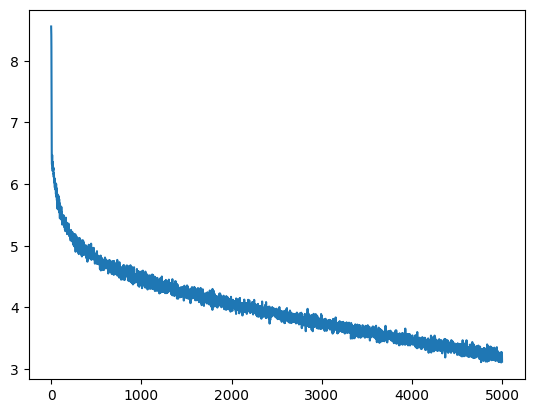

In [99]:
plt.plot(arrayForPlot)
plt.show()

In [108]:
def top_p_sampling(logits, temperature=1.0, top_p=0.9):
    # Ensure logits are a PyTorch tensor and move to DEVICE

    # Apply temperature scaling
    scaled_logits = logits / temperature

    # Convert logits to probabilities using softmax
    probabilities = torch.softmax(scaled_logits, dim=-1)

    # Sort probabilities and compute cumulative sum
    sorted_indices = torch.argsort(probabilities, descending=True)
    sorted_probabilities = probabilities[sorted_indices]
    cumulative_probabilities = torch.cumsum(sorted_probabilities, dim=-1)

    # Apply top-p filtering
    indices_to_keep = cumulative_probabilities <= top_p
    truncated_probabilities = sorted_probabilities[indices_to_keep]

    # Rescale the probabilities
    truncated_probabilities /= torch.sum(truncated_probabilities)

    # Convert to numpy arrays for random choice
    truncated_probabilities = truncated_probabilities.cpu().numpy()
    sorted_indices = sorted_indices.cpu().numpy()
    indices_to_keep = indices_to_keep.cpu().numpy()

    # Sample from the truncated distribution
    if not indices_to_keep.any():
        # Handle the empty case - for example, using regular sampling without top-p
        probabilities = torch.softmax(logits / temperature, dim=-1)
        next_word_index = torch.multinomial(probabilities, 1).item()
    else:
        # Existing sampling process
        next_word_index = np.random.choice(sorted_indices[indices_to_keep], p=truncated_probabilities)

    return torch.tensor(next_word_index).to(DEVICE)


In [109]:
def generate(model, seed_str,
           len_generated_text=50,
           temperature=1, top_p=0.95):
    model.to(DEVICE)
    tokenizer = get_tokenizer("basic_english")
    seed_tokens = tokenizer(seed_str)

    encoded_input = torch.tensor([vocab[t] for t in seed_tokens])
    encoded_input = torch.reshape(encoded_input, (1, -1)).to(DEVICE)

    generated_str = seed_str

    model.eval()
    with torch.inference_mode():
      hidden, cell = model.init_hidden(1)
      hidden = hidden.to(DEVICE)
      cell = cell.to(DEVICE)
      for w in range(len(seed_tokens)-1):
          _, hidden, cell = model(encoded_input[:, w].view(1), hidden, cell)

      last_word = encoded_input[:, -1]
      for i in range(len_generated_text):
          logits, hidden, cell = model(last_word.view(1), hidden, cell)
          logits = torch.squeeze(logits, 0)
          last_word = top_p_sampling(logits, temperature, top_p)
          generated_str += " " + str(vocab.lookup_token(last_word))

    return generated_str.replace(" . ", ". ")

In [110]:
print(generate(model, seed_str='The king'))

The king. said he. shortly went a little further and they stopped. cried the boy. said the master. said the little girl. and now you came two miles away and they went before. they did not intend to put a engagement in the fire and
